# Задание 1. Проведение АА-теста

## Задание 1:

Необходимо сделать симуляцию, как будто мы провели 10000 АА-тестов за период с 27-08-2022 до 02-09-2022. На каждой итерации нам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.
* Построить гистограмму распределения получившихся 10000 p-values.
* Посчитать, какой процент p values оказался меньше либо равен 0.05
* Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

### 1. Загружаем необходимые библиотеки

In [ ]:
import pandahouse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib 
from scipy import stats # статистика
%matplotlib inline
sns.set()

### 2. Подключаемся к нашей базе данных, выбираем наши экспертные группы, 2 и 3, за необходимый период. Определяем значение CTR для пользователей.

In [29]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220920'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-08-27' and '2022-09-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)



### 3. Загружаем полученные данные в датафрейм и строим гистограмму распределения наших CTR для двух групп.

In [30]:
df.head(5)

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [31]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Как видно из таблицы, количество юзеров в двух группах примерно одинаковое

<AxesSubplot:xlabel='ctr', ylabel='Count'>

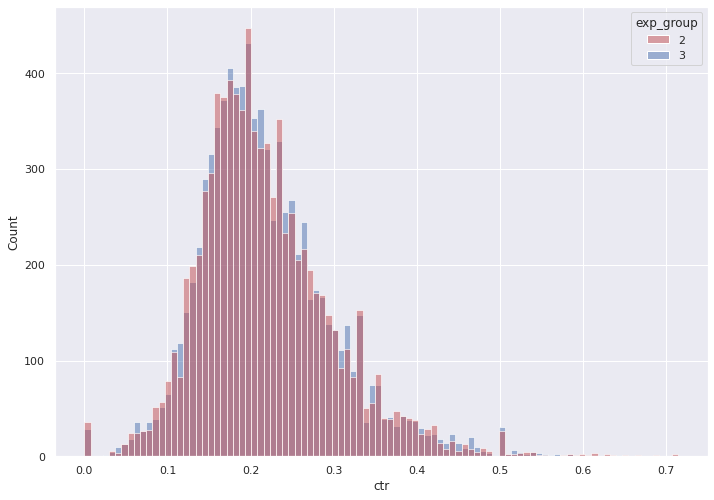

In [66]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На основании полученной гистограммы, можно сделать вывод, что распределение значений CTR для двух групп примерно одинаковое.

### 4. Проведём t-тест для сравнения наших выборок.

In [33]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

Как видно из значения pvalue, наши группы одинаковы

#### 4.1 Также проверим наши выборки с помощью теста Мана-Уитни

In [65]:
stats.mannwhitneyu(df[df.exp_group == 3].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=36540391.5, pvalue=0.5177480614337441)

Значение p-value говорит о равенстве групп

### 5. Сформируем подвыборки размером 500 без повторений и проведём АА-тест 10000 раз. Построим гистограмму распределения значений p-value.

In [67]:
p_values = []

In [68]:
for i in range(10000):
    p_values.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500),
                                    df[df.exp_group == 3].ctr.sample(500),
                                    equal_var=False)[1]) 

Text(0.5, 0, 'p_value')

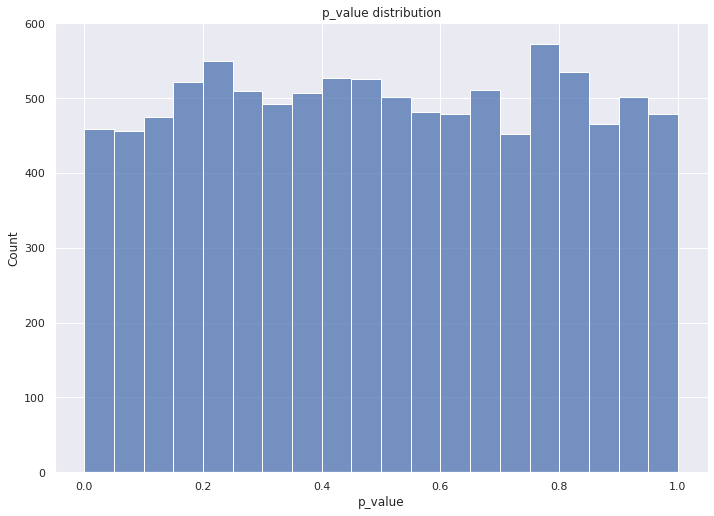

In [69]:
pvalue_hist = sns.histplot(data = p_values,  bins=20) 
pvalue_hist.set_title('p_value distribution')
pvalue_hist.set_xlabel('p_value')

Определим процент тестов, в которых значение p-value было меньше 0.05

In [71]:
share = 0
for i in p_values:
    if (i <= 0.05):
        share += 1

print('Процент p-values со значениями меньше 0.05 : {:.2%}'.format(share/len(p_values)))

Процент p-values со значениями меньше 0.05 : 4.56%


**Вывод. В 4.56% случаев мы получили значение p-value меньше 0.05. То есть, наша система сплитования работает корректно. Мы можем подтвердить гипотезу, что наши выборки равны между собой. Тот факт, что полученный процент p-value, близок к допустимому значению в 5% можно объяснить относительно небольшим размером выборок (500 из 8500), небольшим сроком проведения эксперимента (7 дней), тем, что распределение CTR  в наших группах отличается от нормального. Либо, статистически значимые различия между двумя группами встречались только в результате случайного ложного срабатывания.**